In [ ]:
!pip install nltk
!pip install spacy
!pip install rapidfuzz
!pip install tqdm
!pip install symspellpy
!pip install --upgrade pip setuptools wheel
!pip install --upgrade gensim
!pip install gradio
!pip install tabulate
!python -m spacy download en_core_web_sm

### **Import & Load Data**

In [ ]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## nltk
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

## spacy
import spacy

## gradio
import gradio as gr

In [3]:
df = pd.read_csv("sample_data_sm.csv")
df.head()

,title,ingredients,directions,link,source,NER,site
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""bite size shredded rice biscuits"", ""vanilla""...",www.cookbooks.com
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""cream of mushroom soup"", ""beef"", ""sour cream...",www.cookbooks.com
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""pepper"", ""cream cheese"", ""gar...",www.cookbooks.com
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken gravy"", ""cream of mushroom soup"", ""c...",www.cookbooks.com
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""graham cracker crumbs"", ""powdered sugar"", ""p...",www.cookbooks.com


### **Select useful columns**

In [4]:
df.columns

Index(['title', 'ingredients', 'directions', 'link', 'source', 'NER', 'site'], dtype='object')

In [5]:
df = df[['title', 'ingredients', 'directions', 'NER']].copy()

In [6]:
df.head()

,title,ingredients,directions,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""bite size shredded rice biscuits"", ""vanilla""..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""cream of mushroom soup"", ""beef"", ""sour cream..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""pepper"", ""cream cheese"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken gravy"", ""cream of mushroom soup"", ""c..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""graham cracker crumbs"", ""powdered sugar"", ""p..."


In [7]:
df = df.rename(columns={
    'title': 'recipe_name',
    'ingredients':'ingredients_w_amt',
    'directions':'recipe_steps',
    'NER': 'ingredients_no_amt'})

### **Check for null values or duplicated rows**

In [8]:
df.isna().sum()

recipe_name           0
ingredients_w_amt     0
recipe_steps          0
ingredients_no_amt    0
dtype: int64

In [9]:
df.loc[df.duplicated()]

,recipe_name,ingredients_w_amt,recipe_steps,ingredients_no_amt


In [10]:
len(df)

55779

### **Clean/Lemmatize Ingredients List**

In [11]:
df["ingredient_tokens"] = pd.Series([None]*len(df), dtype="object")  # ensure object dtype

In [12]:
df.head()

,recipe_name,ingredients_w_amt,recipe_steps,ingredients_no_amt,ingredient_tokens
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""bite size shredded rice biscuits"", ""vanilla""...",None
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""cream of mushroom soup"", ""beef"", ""sour cream...",None
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""pepper"", ""cream cheese"", ""gar...",None
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken gravy"", ""cream of mushroom soup"", ""c...",None
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""graham cracker crumbs"", ""powdered sugar"", ""p...",None


#### **Function for fixing misspelled ingredients**

In [32]:
def parse_usda_food_des(path):
    # read raw lines
    with open(path, encoding="latin1") as f:
        lines = [line.rstrip("\n") for line in f if line.strip()]

    # split into fields, strip the surrounding tildes
    records = []
    for line in lines:
        parts = line.split("^")
        # remove outer ~ if present
        parts = [p.strip("~") for p in parts]
        # depending on version: Short and Long desc are at fixed positions
        # According to SR legacy: index 2 = Short_Desc, index 3 = Long_Desc
        if len(parts) >= 4:
            short_desc = parts[2]
            long_desc = parts[3]
            records.append({"short_desc": short_desc, "long_desc": long_desc})
    df = pd.DataFrame.from_records(records)
    return df

# usage
df_food = parse_usda_food_des("FOOD_DES.txt")
# preview normalized base ingredient names (you can further simplify)
df_food["base_term"] = (
    df_food["short_desc"]
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)  # remove punctuation
    .str.replace(r"\s+", "_", regex=True)     # spaces -> underscore
)
print(df_food[["short_desc", "base_term"]].head())


                   short_desc                 base_term
0              Butter, salted             butter_salted
1  Butter, whipped, with salt  butter_whipped_with_salt
2       Butter oil, anhydrous      butter_oil_anhydrous
3                Cheese, blue               cheese_blue
4               Cheese, brick              cheese_brick


In [33]:
proper_ingredients_names = set()

for lst in df_food["base_term"].str.split("_").values:
    res = []
    for word in lst:
        if len(word) <= 1:
            continue
        res.append(re.sub('[^a-zA-Z]', ' ', word))
    proper_ingredients_names.update(res)

In [34]:
import difflib
from symspellpy import SymSpell, Verbosity
from collections import Counter

# tuning: how fuzzy to allow for fallback
FUZZY_CUTOFF = 0.6  # adjust between 0.5 and 0.8

# initialize SymSpell
max_edit_distance = 2
prefix_length = 7
sym_spell = SymSpell(max_dictionary_edit_distance=max_edit_distance, prefix_length=prefix_length)

def correct_spelling(token):
    query = token.lower()
    # 1. If it's already a trusted ingredient, keep it
    if query in proper_ingredients_names:
        return query

    # 2. SymSpell suggestions
    suggestions = sym_spell.lookup(query, Verbosity.CLOSEST, max_edit_distance)
    if suggestions:
        top = suggestions[0]
        if top.term in proper_ingredients_names and top.term != query:
            return top.term  # eg. 'galric' -> 'garlic'
        # if symspell just returns the same word (like 'cherish'), proceed to fuzzy fallback

    # 3. Fuzzy match against proper_ingredients_names
    close = difflib.get_close_matches(query, proper_ingredients_names, n=1, cutoff=FUZZY_CUTOFF)
    if close:
        return close[0]

    # 4. Fallback to original
    return query

# test 
print(correct_spelling("cherish"))  
print(correct_spelling("boulline"))
print(correct_spelling("buttr"))  

cherries
bouillon
butter


### **Lemmatize & Clean Words**

In [ ]:
from tqdm.auto import tqdm

wl = WordNetLemmatizer()
stopset = set(stopwords.words("english"))

corpus = []

for i in tqdm(range(len(df)), desc="Processing recipes"):
    recipe_tokens = []
    ingredient_lst = json.loads(df['ingredients_no_amt'][i])
    
    for ingredient in ingredient_lst:
        # remove non-english terms and convert to lowercase
        text_data = re.sub('[^a-zA-Z]', ' ', ingredient)
        text_data = text_data.lower()
        text_data = text_data.split()
        # fix spelling before lemmatizing
        text_data = [correct_spelling(word) for word in text_data]
        # lemmatize
        text_data = [wl.lemmatize(word) for word in text_data if not word in stopset]
        recipe_tokens.extend(text_data)
        
    corpus.append(recipe_tokens)
    
df["ingredient_tokens"] = corpus

In [17]:
df.head()

,recipe_name,ingredients_w_amt,recipe_steps,ingredients_no_amt,ingredient_tokens
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""bite size shredded rice biscuits"", ""vanilla""...","[bite, size, shredded, rice, biscuit, vanilla,..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""cream of mushroom soup"", ""beef"", ""sour cream...","[cream, mushroom, soup, beef, sour, cream, chi..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""pepper"", ""cream cheese"", ""gar...","[frozen, corn, pepper, cream, cheese, garlic, ..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken gravy"", ""cream of mushroom soup"", ""c...","[chicken, gravy, cream, mushroom, soup, chicke..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""graham cracker crumbs"", ""powdered sugar"", ""p...","[graham, cracker, crumb, powdered, sugar, pean..."


### **Clean up other columns - convert to list of strings**

In [18]:
ingredients_w_amt_lst = []
ingredients_no_amt_lst = []
recipe_steps_lst = []

for i in range(0, len(df)):
    ingredients_w_amt_lst.append(json.loads(df['ingredients_w_amt'][i]))
    ingredients_no_amt_lst.append(json.loads(df['ingredients_no_amt'][i]))
    recipe_steps_lst.append(json.loads(df['recipe_steps'][i]))

df["ingredients_w_amt"] = ingredients_w_amt_lst
df["ingredients_no_amt"] = ingredients_no_amt_lst
df["recipe_steps"] = recipe_steps_lst


In [19]:
df.head()

,recipe_name,ingredients_w_amt,recipe_steps,ingredients_no_amt,ingredient_tokens
0,No-Bake Nut Cookies,"[1 c. firmly packed brown sugar, 1/2 c. evapor...","[In a heavy 2-quart saucepan, mix brown sugar,...","[bite size shredded rice biscuits, vanilla, br...","[bite, size, shredded, rice, biscuit, vanilla,..."
1,Jewell Ball'S Chicken,"[1 small jar chipped beef, cut up, 4 boned chi...","[Place chipped beef on bottom of baking dish.,...","[cream of mushroom soup, beef, sour cream, chi...","[cream, mushroom, soup, beef, sour, cream, chi..."
2,Creamy Corn,"[2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. c...","[In a slow cooker, combine all ingredients. Co...","[frozen corn, pepper, cream cheese, garlic pow...","[frozen, corn, pepper, cream, cheese, garlic, ..."
3,Chicken Funny,"[1 large whole chicken, 2 (10 1/2 oz.) cans ch...","[Boil and debone chicken., Put bite size piece...","[chicken gravy, cream of mushroom soup, chicke...","[chicken, gravy, cream, mushroom, soup, chicke..."
4,Reeses Cups(Candy),"[1 c. peanut butter, 3/4 c. graham cracker cru...",[Combine first four ingredients and press in 1...,"[graham cracker crumbs, powdered sugar, peanut...","[graham, cracker, crumb, powdered, sugar, pean..."


### **Word2Vec Model Experimentation - tuning parameters**

In [35]:
from gensim.models import Word2Vec

In [21]:
import math
import matplotlib.pyplot as plt

def plot_neighbors_grid(model, words, topn=8, cols=None):
    n = len(words)
    if cols is None:
        cols = int(math.ceil(math.sqrt(n)))
    rows = int(math.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), squeeze=False)
    for idx, word in enumerate(words):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        try:
            neighbors = model.wv.most_similar(word, topn=topn)
            labels, sims = zip(*neighbors)
            x_pos = range(len(labels))
            bars = ax.bar(x_pos, sims, align='center')
            ax.set_xticks(x_pos)
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
            ax.set_ylim(0, 1)
            ax.set_ylabel("Cosine sim")
            ax.set_title(word)

            # annotate each bar with its similarity value
            for bar, sim in zip(bars, sims):
                height = bar.get_height()
                ax.annotate(f"{sim:.3f}",
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # offset upward
                            textcoords="offset points",
                            ha="center",
                            va="bottom",
                            fontsize=7)
        except KeyError:
            ax.text(0.5, 0.5, f"'{word}'\nnot in vocab", ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])

    # hide any unused subplots
    for empty_idx in range(n, rows * cols):
        r = empty_idx // cols
        c = empty_idx % cols
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()


In [22]:
# first model architecture
model = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=100,      
    window=5,            
    min_count=2,          
    sg=1,                 
    negative=10,          
    epochs=100,           
    workers=2,
    sample=1e-4          
)

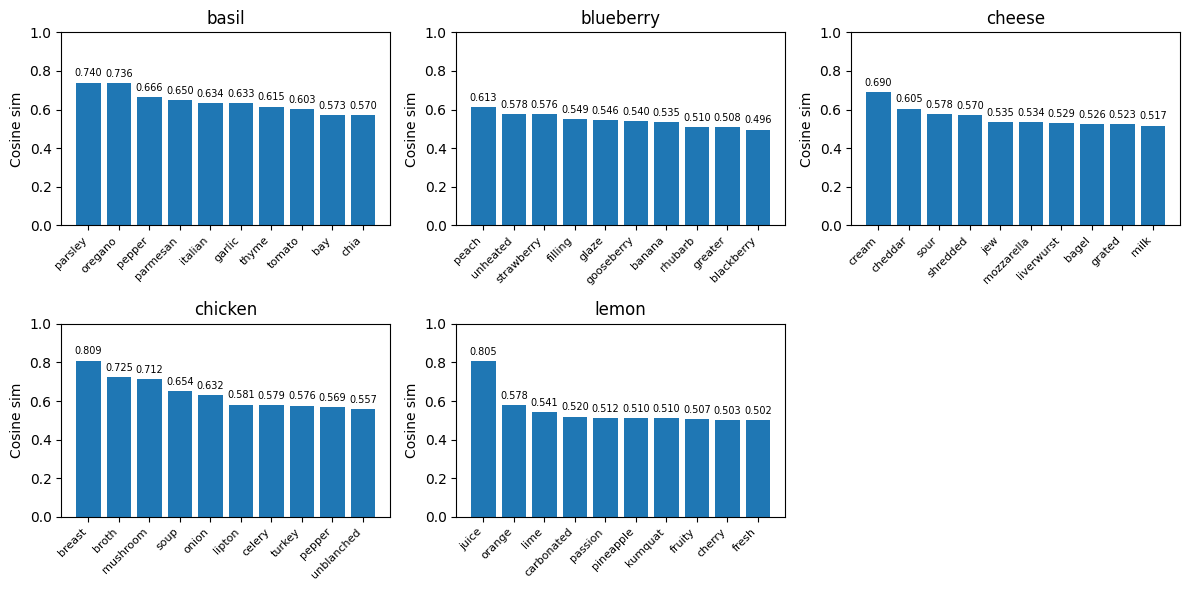

In [23]:
plot_neighbors_grid(model, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

In [24]:
# increase vector size to test
model2 = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=200,
    window=5,
    min_count=2,
    sg=1,
    negative=7,
    sample=1e-4,
    epochs=100,
    workers=2,
)

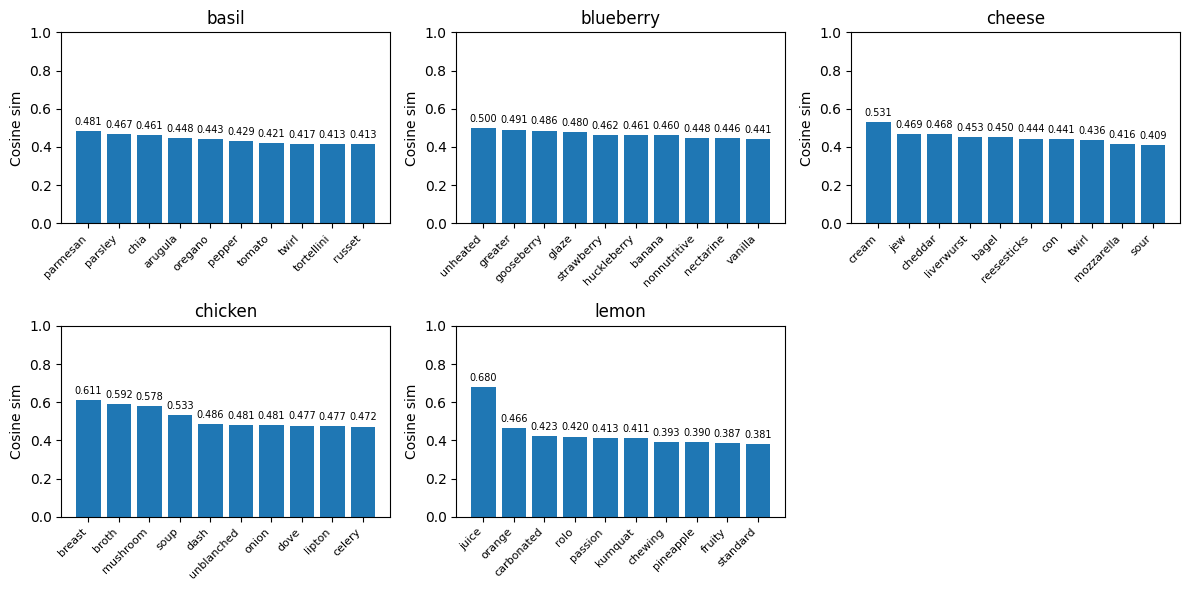

In [25]:
plot_neighbors_grid(model2, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

In [26]:
# decrease vector size, decrease window size to test
model3 = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=50,
    window=3,
    min_count=2,
    sg=1,
    negative=7,
    sample=1e-4,
    epochs=100,
    workers=2,
)

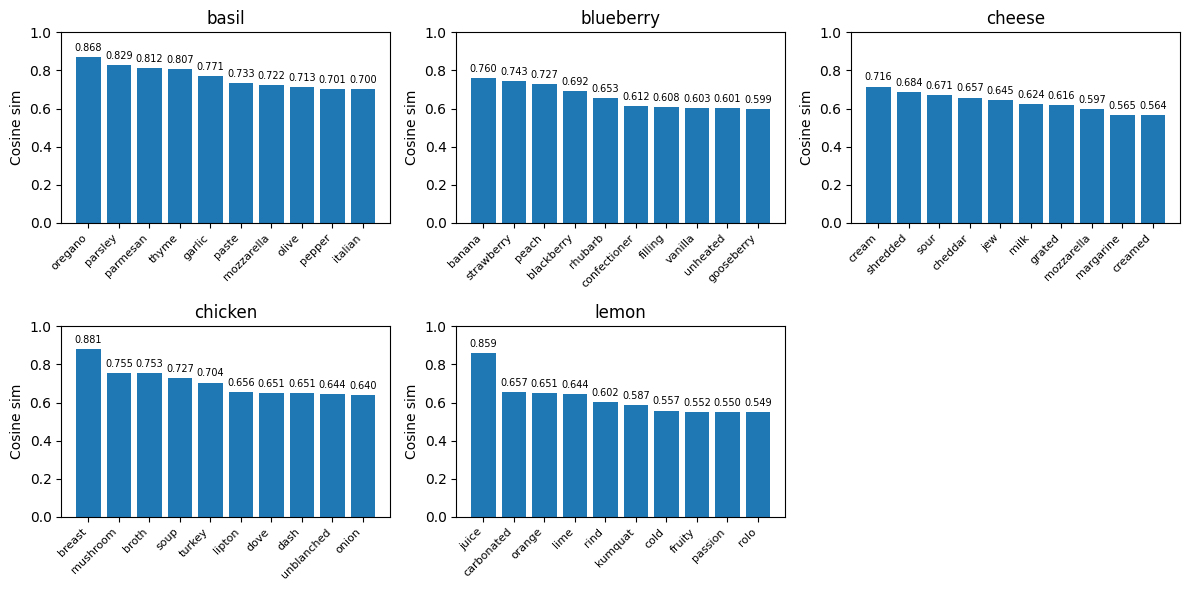

In [27]:
plot_neighbors_grid(model3, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

In [28]:
# keep window size, increase vector size, increase no. of epochs to test
model4 = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=80,
    window=3,
    min_count=2,
    sg=1,
    negative=7,
    sample=1e-4,
    epochs=150,
    workers=2,
)

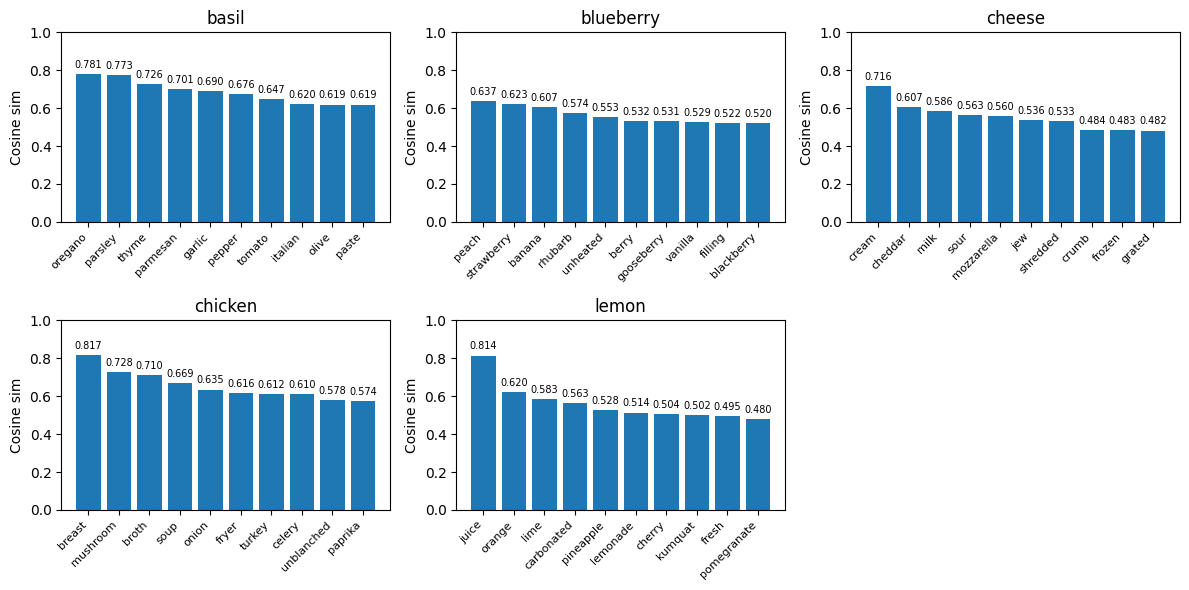

In [29]:
plot_neighbors_grid(model4, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

In [30]:
# try CBOW instead of skip-gram
model5 = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=50,
    window=3,
    min_count=2,
    sg=0,
    negative=7,
    sample=1e-4,
    epochs=150,
    workers=2,
)

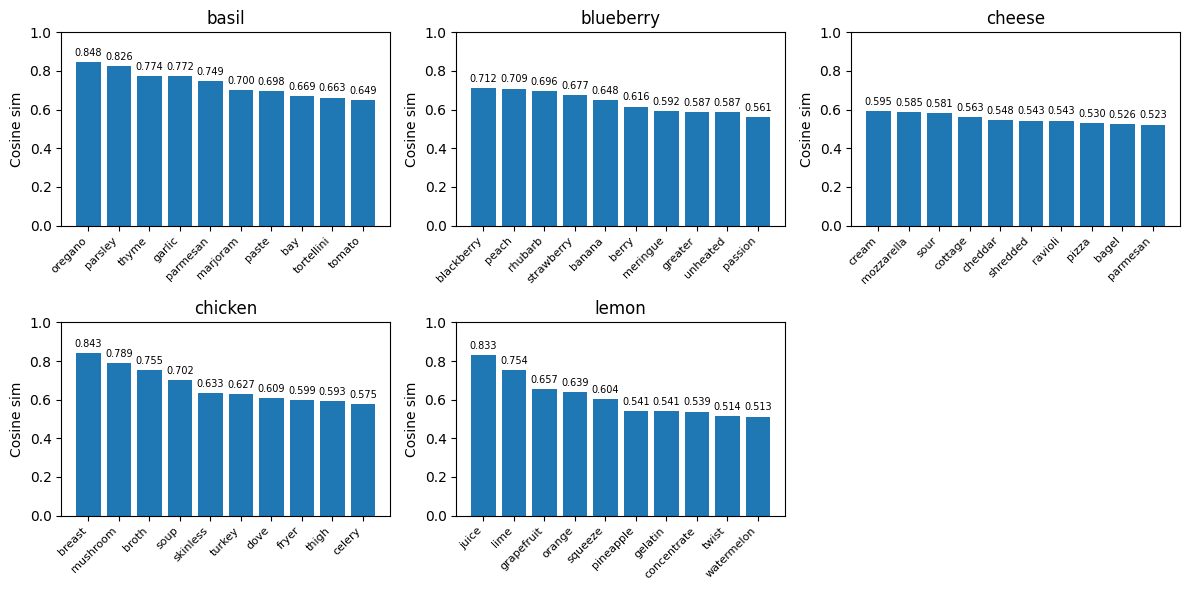

In [31]:
plot_neighbors_grid(model5, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

In [32]:
# increase no. of epochs, increase window size by 1, increase min_count, increase negative samples 
model6 = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=50,
    window=3,
    min_count=3,
    sg=0,
    negative=9,
    sample=1e-4,
    epochs=200,
    workers=3,
)

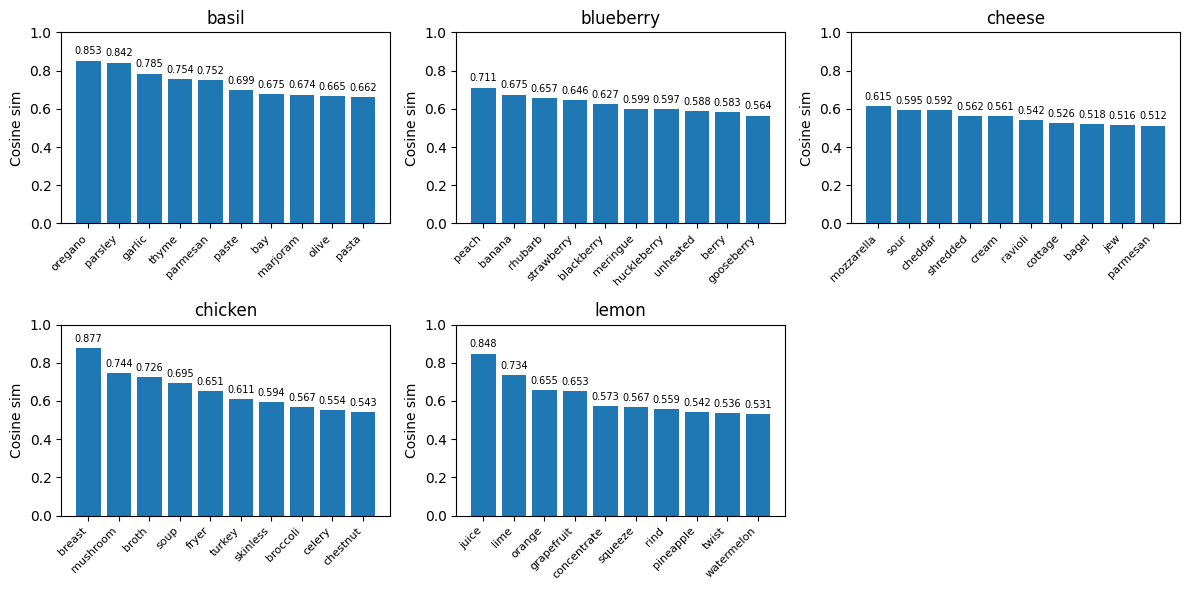

In [33]:
plot_neighbors_grid(model6, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

In [54]:
# use model 6 parameters but skip-gram
model7 = Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=50,
    window=3,
    min_count=3,
    sg=1,
    negative=9,
    sample=1e-4,
    epochs=200,
    workers=3,
)

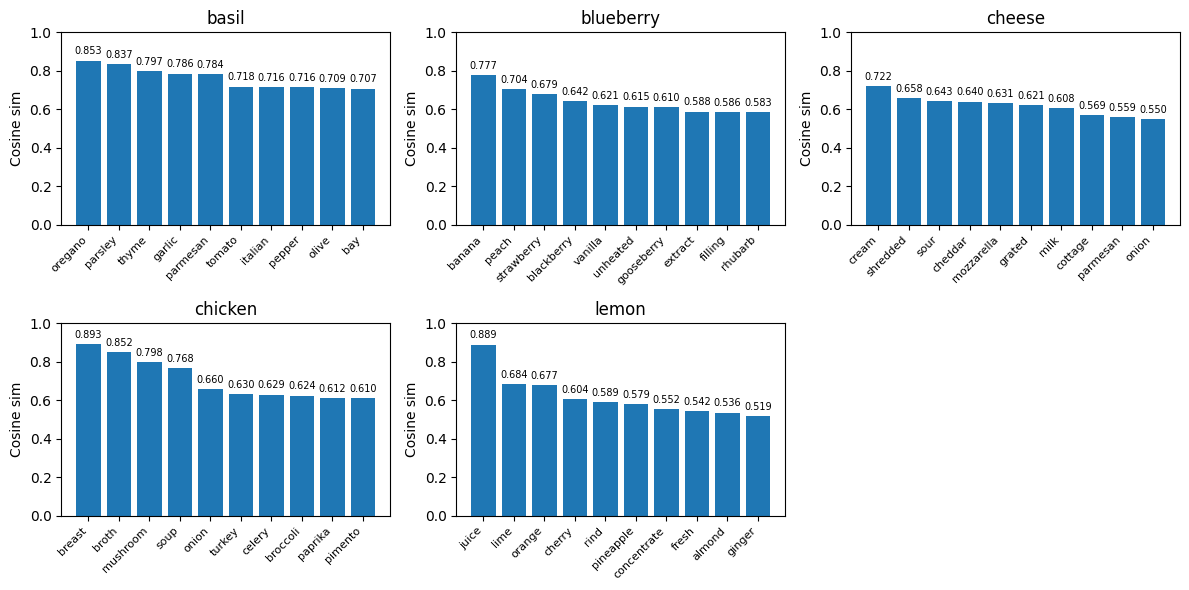

In [35]:
plot_neighbors_grid(model7, ['basil', 'blueberry', 'cheese', 'chicken', 'lemon'], 10)

## Models 1-7 Performance Analysis

Seven Word2Vec models (m1–m7) were evaluated using nearest neighbors for the target words: **basil, blueberry, cheese, chicken,** and **lemon**. The quality of each model can be assessed by (1) the similarity scores (higher is better) and (2) the semantic relevance of top neighbors.

### Key Observations

- **Model m2** is notably weaker, with significantly lower similarity scores across all words (often below 0.7) and more noise in the top neighbors (e.g., "twirl" and "nonnutritive").
- **Models m1, m3, m4, m5, m6, and m7** all show much higher similarity values (many scores above 0.8 for key neighbors) and consistently return relevant culinary associations.
- **m7** outperforms all others, with the highest similarity scores for almost every target (e.g., *chicken–breast: 0.893*, *lemon–juice: 0.889*, *basil–oregano: 0.853*), and the nearest neighbors are all semantically appropriate.
- **m3, m6, and m7** are closely matched, but m7 edges out the others in both raw score and coherence (neighbors are always logical).
- **m1** and **m4** perform well but have slightly lower similarity scores compared to the best performers.

### Conclusion

**We will choose model m7 to work with.**  
It achieves the highest similarity scores, consistently returns highly relevant neighbors, and displays robust semantic relationships across diverse food-related terms.


## **Compute average word vector for each recipe**

In [10]:
def compute_recipe_vector(tokens, model):
    vecs = []
    for t in tokens:
        if t in model.wv:
            vecs.append(model.wv[t])
    if not vecs:
        # fallback: zero vector (or could return None and filter later)
        return np.zeros(model.vector_size, dtype=float)
    arr = np.stack(vecs)                  # shape: (num_tokens, dim)
    avg = arr.mean(axis=0)                # average
    norm = np.linalg.norm(avg)
    if norm > 0:
        avg = avg / norm                  # normalize to unit length (helps cosine)
    return avg

df["recipe_vec"] = df["ingredient_tokens"].apply(lambda toks: compute_recipe_vector(toks, model7))


In [11]:
df.head()

,recipe_name,ingredients_w_amt,recipe_steps,ingredients_no_amt,ingredient_tokens,recipe_vec
0,No-Bake Nut Cookies,"['1 c. firmly packed brown sugar', '1/2 c. eva...","['In a heavy 2-quart saucepan, mix brown sugar...","['bite size shredded rice biscuits', 'vanilla'...","[bite, size, shredded, rice, biscuit, vanilla,...","[0.073301286, -0.1090485, -0.09272982, -0.0075..."
1,Jewell Ball'S Chicken,"['1 small jar chipped beef, cut up', '4 boned ...",['Place chipped beef on bottom of baking dish....,"['cream of mushroom soup', 'beef', 'sour cream...","[cream, mushroom, soup, beef, sour, cream, chi...","[0.030386575, -0.1461351, -0.29809114, 0.07750..."
2,Creamy Corn,"['2 (16 oz.) pkg. frozen corn', '1 (8 oz.) pkg...","['In a slow cooker, combine all ingredients. C...","['frozen corn', 'pepper', 'cream cheese', 'gar...","[frozen, corn, pepper, cream, cheese, garlic, ...","[-0.0048662266, -0.16175152, -0.23520106, -0.0..."
3,Chicken Funny,"['1 large whole chicken', '2 (10 1/2 oz.) cans...","['Boil and debone chicken.', 'Put bite size pi...","['chicken gravy', 'cream of mushroom soup', 'c...","[chicken, gravy, cream, mushroom, soup, chicke...","[-0.031070145, -0.06922721, -0.19735363, 0.144..."
4,Reeses Cups(Candy),"['1 c. peanut butter', '3/4 c. graham cracker ...",['Combine first four ingredients and press in ...,"['graham cracker crumbs', 'powdered sugar', 'p...","[graham, cracker, crumb, powdered, sugar, pean...","[0.03485634, -0.14240739, -0.19660501, -0.0439..."


## Hybrid Recipe Recommendation Approach

Combine average vector cosine similarity with fine-grained token matching for robust recommendations.

### 1. Vectors
- **Recipe vector:** normalized average of its ingredient embedding vectors.  
- **Query vector:** same treatment on user-provided ingredient list (after spelling/domain correction).

### 2. Retrieval & scoring
1. **Initial candidate retrieval:**  
   Compute cosine similarity between the query vector and all precomputed recipe vectors (fast dot product) to get top-(k+50) candidates.
   We get k+50 top recipes such that we have some buffer for re-ranking in the later steps.
3. **Refinement with per-word matching:**  
   For each query token, find its highest cosine similarity to any token in the candidate recipe (i.e., max over recipe tokens), and average those per-token scores to get a `per_word_score` (captures partial/near matches).  
4. **Combined score:**  
```
final_score = α * cosine(query_vec, recipe_vec) + (1 - α) * per_word_score
```
Tune α (e.g., 0.6/0.4) depending on whether global coherence or exact ingredient overlap is more important.  

### 3. Further Enhancement: TF-IDF to penalize common ingredients (e.g. salt, sugar)
- Compute TF-IDF values for top-(k+50) recipes returned.
- Update the per-word similarity scoring computation to include TF-IDF weights computed for the word in that recipe.
- Re-rank based on the final TF-IDF weighted similarity scores.

### **1. Getting top-k recipes only with similarity of average word vector**

In [12]:
user_ingredients_input = input("What ingredients do you have on hand?: ")

What ingredients do you have on hand?:  dark chocolat, flour sugar buttter, whole milk, eggs, vanilla, chicken, salt,


#### **Clean and preprocess user input**

In [17]:
def clean_user_input(raw):
    tokens = []
    for part in raw.split(","):
        for word in part.strip().lower().split():
            word = re.sub(r"[^a-z]", "", word)
            if word:
                word = correct_spelling(word)
                tokens.append(word)
    return tokens

user_input_tokens = clean_user_input(user_ingredients_input)
print(user_input_tokens)

['dark', 'chocolate', 'flour', 'sugar', 'butter', 'whole', 'milk', 'eggs', 'vanilla', 'chicken', 'salt']


#### **Compute average word vector for user input**

In [18]:
user_input_avg_vec = compute_recipe_vector(user_input_tokens, model7)

In [19]:
print(user_input_avg_vec)

[ 0.0264006  -0.10584599 -0.19513223  0.05600359 -0.09957528  0.05512426
  0.14857726  0.46365896 -0.14591895 -0.10486709  0.20699273 -0.08615007
  0.11083078  0.07914541 -0.03886901  0.11965203  0.11021084  0.00618799
 -0.272212   -0.10771033  0.00529786 -0.00265495  0.37978247  0.15977143
  0.15700737 -0.04595873 -0.07183874  0.02806422 -0.16124184 -0.01494745
 -0.05113244 -0.1600963   0.01570512 -0.14244808 -0.05841669  0.01517686
  0.13927108  0.0484554  -0.0343716  -0.03968743  0.08750495 -0.13187368
 -0.01377971 -0.02539362  0.2930847  -0.04098111 -0.01944798 -0.17717004
 -0.10907555 -0.13883935]


In [20]:
## DEFINE K
CONST_K = 5

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0

    return dot_product / (norm_vec1 * norm_vec2)

def get_top_n_recipes_fullrow(query_vec, df, topk=CONST_K):
    df["cosine_similarity"] = df["recipe_vec"].apply(lambda vec: cosine_similarity(vec, query_vec))

    df = df.sort_values("cosine_similarity", ascending=False)
    # get top-(k+10) for buffer for later refinement of similarity score to get final top-k recipes
    return df.iloc[:topk + 10]
    

pd.set_option("display.max_colwidth", None) 

top_recipes = get_top_n_recipes_fullrow(user_input_avg_vec, df)
cols = ["recipe_name", "ingredients_w_amt", "cosine_similarity"]
display(
    top_recipes[cols]
    .style
    .set_properties(**{
        "white-space": "normal",  
        "word-wrap": "break-word",
    })
)

,recipe_name,ingredients_w_amt,cosine_similarity
917,Betsy'S Chocolate Fudge Cake,"['3 sq. unsweetened chocolate', '2 1/4 c. sifted flour', '2 tsp. baking powder', '1/2 tsp. salt', '1/2 c. butter', '2 1/4 c. packed light brown sugar', '3 eggs', '1 1/2 tsp. vanilla', '1 c. sour cream', '1 c. boiling water']",0.953638
18020,Candy Store Cake,"['2 c. sugar', '2 sticks butter', '4 eggs', '1 c. buttermilk', '1/2 tsp. salt', ""1 can (16 oz.) Hershey's chocolate syrup"", '2 tsp. vanilla', '6 Hershey bars, melted over hot water', '2 1/2 c. flour']",0.953401
18758,Chambord Brownies,"['1 c. sugar', '1 stick butter', '4 eggs, beaten', '1 c. flour', '1/2 tsp. salt', '1 (16 oz.) can chocolate syrup']",0.951257
51907,Caramel And Chocolate Slice,"['1 c. self-rising flour', '1 c. brown sugar', '1 c. coconut', '10 Tbsp. butter', '16 oz. can condensed milk', '2 Tbsp. dark corn syrup', '6 oz. cooking chocolate', '1 1/2 Tbsp. vegetable shortening']",0.950191
19054,Potato Fudge Cake,"['2 c. sugar', '1 c. butter', '1 c. white potatoes, boiled and put through strainer', '3/4 c. milk', '2 c. all-purpose flour', '4 eggs', '2 tsp. baking powder', '1/2 tsp. salt', '3 sq. melted chocolate (unsweetened)', '1 tsp. vanilla']",0.949226
30121,Chocolate Nut Upside-Down Cake,"['10 Tbsp. butter or margarine', '1/4 c. firmly packed light brown sugar', '2/3 c. light corn syrup', '1/4 c. heavy cream', '1 c. broken walnuts', '1 3/4 c. sifted cake flour', '2 tsp. baking powder', '1/4 tsp. salt', '1 1/2 c. granulated sugar', '2 eggs, separated', '3 sq. unsweetened chocolate, melted', '1 tsp. vanilla extract', '1 c. milk']",0.949092
22932,Yummy Jif Bars,"['1 c. peanut butter', '2/3 c. margarine, melted', '3 eggs', '2 c. packed brown sugar', '1 tsp. vanilla', '1 c. flour', '1/2 tsp. salt', '3/4 c. powdered sugar', '2 tsp. water', '1/4 c. chocolate chips', '1 Tbsp. margarine']",0.948887
32242,Chocolate Syrup Cake,"['1 stick margarine', '1 c. sugar', '4 eggs', '1 c. flour', '1 tsp. baking powder', 'pinch of salt', '1 tsp. vanilla', ""1 large can Hershey's chocolate syrup""]",0.948816
21547,"Peanut Butter ""Tastycake""","['1 c. milk', '2 Tbsp. butter', '4 eggs', '2 c. white sugar', '1 tsp. vanilla', '2 c. flour', '2 tsp. baking powder', '12 oz. creamy peanut butter', '6 oz. milk chocolate or 3 oz. semi-sweet chocolate bits']",0.947991
20088,Favorite Chocolate Brownies(Microwave),"['1/4 c. butter', '1/2 c. sugar', '2 eggs', '1/4 tsp. vanilla', '1/2 c. sifted flour', '1/2 c. chocolate flavored ice cream syrup', '1/4 tsp. salt']",0.947672


### **2. Refinement of top results with per-word matching**

In [21]:
def per_word_score(query_tokens, recipe_tokens, model):
    score = 0.0
    count = 0
    for q in query_tokens:
        if q not in model.wv:
            continue
        sims = []
        for r in recipe_tokens:
            if r in model.wv:
                sims.append(model.wv.similarity(q, r))
        if sims:
            score += max(sims)  # best match for this query word
            count += 1
    return score / count if count else 0.0

In [22]:
def update_word_scores_for_top_recipes(top_recipes, user_input_tokens):
    word_scores = []
    for index, recipe in top_recipes.iterrows():
        recipe_tokens = recipe['ingredient_tokens']
        word_scores.append(per_word_score(user_input_tokens, recipe_tokens, model7))
    top_recipes["per_word_score"] = word_scores
    
update_word_scores_for_top_recipes(top_recipes, user_input_tokens)

In [23]:
def update_similarity_scores(top_recipes, alpha=0.6):
    top_recipes["final_similarity"] = (
        alpha * top_recipes["cosine_similarity"] + (1 - alpha) * top_recipes["per_word_score"]
    )
    
update_similarity_scores(top_recipes, 0.6)
# sort by the new score, get the final top-k recipe recommendations
top_recipes = top_recipes.sort_values("final_similarity", ascending=False)
final_top_k_recipes = top_recipes.iloc[:CONST_K]

In [24]:
cols = ["recipe_name", "ingredients_w_amt", "final_similarity"]
display(
    final_top_k_recipes[cols]
    .style
    .set_properties(**{
        "white-space": "normal",  
        "word-wrap": "break-word",
    })
)

,recipe_name,ingredients_w_amt,final_similarity
30121,Chocolate Nut Upside-Down Cake,"['10 Tbsp. butter or margarine', '1/4 c. firmly packed light brown sugar', '2/3 c. light corn syrup', '1/4 c. heavy cream', '1 c. broken walnuts', '1 3/4 c. sifted cake flour', '2 tsp. baking powder', '1/4 tsp. salt', '1 1/2 c. granulated sugar', '2 eggs, separated', '3 sq. unsweetened chocolate, melted', '1 tsp. vanilla extract', '1 c. milk']",0.912248
19054,Potato Fudge Cake,"['2 c. sugar', '1 c. butter', '1 c. white potatoes, boiled and put through strainer', '3/4 c. milk', '2 c. all-purpose flour', '4 eggs', '2 tsp. baking powder', '1/2 tsp. salt', '3 sq. melted chocolate (unsweetened)', '1 tsp. vanilla']",0.900894
917,Betsy'S Chocolate Fudge Cake,"['3 sq. unsweetened chocolate', '2 1/4 c. sifted flour', '2 tsp. baking powder', '1/2 tsp. salt', '1/2 c. butter', '2 1/4 c. packed light brown sugar', '3 eggs', '1 1/2 tsp. vanilla', '1 c. sour cream', '1 c. boiling water']",0.900120
45850,Hot Fudge Sauce,"['1/4 c. butter', '2 c. sugar', '3 sq. chocolate', '2 Tbsp. flour', '2 large cans evaporated milk', '1/2 tsp. vanilla', 'pinch of salt']",0.896230
22932,Yummy Jif Bars,"['1 c. peanut butter', '2/3 c. margarine, melted', '3 eggs', '2 c. packed brown sugar', '1 tsp. vanilla', '1 c. flour', '1/2 tsp. salt', '3/4 c. powdered sugar', '2 tsp. water', '1/4 c. chocolate chips', '1 Tbsp. margarine']",0.895307


### **3. Further Enhancement: TF-IDF to penalize common ingredients (e.g. salt, sugar)**

**TF**: number of times ingredient term occurs in the recipe's ingredient list / number of terms in the recipe's ingredient list

**IDF**: log of (number of recipes / number of recipes with ingredient list containing that ingredient term)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_tokens = df['ingredient_tokens'].copy()
df_tokens = df_tokens.apply(lambda token_lst: " ".join(token_lst))

vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(df_tokens.values)
dict(zip(vectorizer.get_feature_names_out(), vector.toarray()[0]))

tfidf_df = pd.DataFrame(
    vector.toarray(), index=df['recipe_name'], columns=vectorizer.get_feature_names_out()
)

#### Convert matrix into dictionaries of TF-IDF values for each ingredient term in each recipe

In [26]:
cleaned_tfidf_dict = tfidf_df.apply(lambda row: row[row.ne(0) & row.notna()].to_dict(), axis=1).to_dict()

### **Updated Per-Word Score Computation**

We use the TF-IDF values computed as weights to apply to the similarity score during the per-word similarity score computation.
Also, instead of taking the max of the similarity scores computed, we take the mean to penalize missing ingredients. (such that recipes with too many missing ingredients are penalized.)

In [28]:
def per_word_score_with_tfidf_weights(query_tokens, recipe_tokens, model, cleaned_tfidf_dict, alpha=0.7):
    score = 0.0
    count = 0
    for q in query_tokens:
        if q not in model.wv:
            continue
        sims = []
        for r in recipe_tokens:
            if r in model.wv:
                similarity = model.wv.similarity(q, r)
                if r in cleaned_tfidf_dict:
                    tfidf_val = cleaned_tfidf_dict[r]
                else:
                    tfidf_val = 0
                tfidf_weighted_similarity = alpha * similarity + (1 - alpha) * tfidf_val
                sims.append(tfidf_weighted_similarity)            
                
        if sims:
            score += np.mean(sims)  # use mean to penalize missing ingredients
            count += 1
    return score / count if count else 0.0

In [29]:
def update_tfidf_weighted_scores_for_top_recipes(top_recipes, model, tfidf_dict, user_input_tokens):
    word_scores = []
    for _, recipe in top_recipes.iterrows():
        recipe_tokens = recipe['ingredient_tokens']
        word_scores.append(per_word_score_with_tfidf_weights(user_input_tokens, recipe_tokens, model, tfidf_dict, 0.6))
    top_recipes["tfidf_weighted_per_word_score"] = word_scores
    
update_tfidf_weighted_scores_for_top_recipes(top_recipes, model7, cleaned_tfidf_dict, user_input_tokens)

In [30]:
def update_tfidf_weighted_similarity_scores(top_recipes, alpha=0.7):
    top_recipes["final_weighted_similarity"] = (
        alpha * top_recipes["cosine_similarity"] + (1 - alpha) * top_recipes["tfidf_weighted_per_word_score"]
    )
    
update_tfidf_weighted_similarity_scores(top_recipes, 0.6)
# sort by the new score, get the final top-k recipe recommendations
top_recipes = top_recipes.sort_values("final_weighted_similarity", ascending=False)
final_top_k_recipes = top_recipes.iloc[:CONST_K]

In [31]:
cols = ["recipe_name", "ingredients_w_amt", "final_weighted_similarity", "tfidf_weighted_per_word_score"]
display(
    final_top_k_recipes[cols]
    .style
    .set_properties(**{
        "white-space": "normal",  
        "word-wrap": "break-word",
    })
)

,recipe_name,ingredients_w_amt,final_weighted_similarity,tfidf_weighted_per_word_score
20088,Favorite Chocolate Brownies(Microwave),"['1/4 c. butter', '1/2 c. sugar', '2 eggs', '1/4 tsp. vanilla', '1/2 c. sifted flour', '1/2 c. chocolate flavored ice cream syrup', '1/4 tsp. salt']",0.695681,0.317695
45850,Hot Fudge Sauce,"['1/4 c. butter', '2 c. sugar', '3 sq. chocolate', '2 Tbsp. flour', '2 large cans evaporated milk', '1/2 tsp. vanilla', 'pinch of salt']",0.694946,0.316371
18758,Chambord Brownies,"['1 c. sugar', '1 stick butter', '4 eggs, beaten', '1 c. flour', '1/2 tsp. salt', '1 (16 oz.) can chocolate syrup']",0.694801,0.310118
5315,Creme De Menthe Brownies,"['1 c. sugar', '4 beaten eggs', '1/2 tsp. salt', '1 tsp. vanilla', '1/2 c. soft butter', '1 c. flour', ""1 c. Hershey's chocolate syrup""]",0.691988,0.309177
40027,Chocolate Mint Squares,"['1 c. sugar', '1/2 c. butter or oleo', '4 eggs', '1 c. all-purpose flour', '1/2 tsp. salt', '1 (16 oz.) can chocolate syrup', '1 tsp. vanilla']",0.691988,0.309177


## **Conclusion**
This project built a hybrid recipe recommendation system grounded in a tailored Word2Vec embedding of ingredients and refined with per-word matching and TF-IDF weighting to down-weigh common ingredients (eg. salt, sugar).


### **Model Selection**
After evaluating seven Word2Vec variants (m1–m7) on neighbor coherence and similarity strength, **model m7** was chosen for its better semantic fidelity and highest overall similarity scores to good neighbors.

**model m7** was trained with following parameters:
```
Word2Vec(
    sentences=df["ingredient_tokens"],
    vector_size=50,
    window=3,
    min_count=3,
    sg=1,
    negative=9,
    sample=1e-4,
    epochs=200,
    workers=3,
)
```

### **Hybrid Ranking Approach**
Recipes are first retrieved via average word-vector similarity and then re-ranked through a per-word similarity scoring weighted with pre-computed TF-IDF scores to reduce noise from common ingredients.

### **Strengths**
- Data pre-processing handles spelling correction and lemmatization
- Hybrid approach combines global (average vector) and local (per-term) weights
- Recipe with missing ingredients are penalized in similarity score accordingly
- Initial retrieval of top-(k + 50) recipes reduces unnecessary computation of per-word scoring for irrelevant recipes, increasing computational efficiency

### **Limitations**
- TF-IDF weights may affect main ingredients that are more common (eg. chicken, beef)
- Current recommendations ignore contextual cooking constraints (e.g., dietary restrictions or ingredient quantities beyond presence)
- Currently relies on static embeddings which may miss nuanced phrase-level semantics

### **Learning Outcomes**
- Data exploration of embedding neighborhoods and model behavior with matplotlib
- Data pre-processing and formatting (eg. cleaning, tokenization, lemmatization, fixing spelling with SymSpell)
- Word embeddings trained with Word2Vec and document-level representation via average word vectors
- Scoring approach aggregating per-term cosine similarity with TF-IDF
- Designing a multi-stage retrieval pipeline that balances coarse-grained and fine-grained relevance signals
- Gradio demo creation to simulate end-to-end workflow

### **Created Simple Demo on HuggingFace Spaces**
https://huggingface.co/spaces/wenjin-lee/nlp-recipe-recommender-demo
